In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import tensorflow as tf
import time

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

from helper.file_system_interaction import load_object_from_file

ModuleNotFoundError: No module named 'helper'

In [2]:
users = load_object_from_file("tmp_small.pickle")

# print(f"Type of users: {type(users)}\nLength of Users: {len(users)}\nFirst user of users: {list(users)[0]}")
# print(users[1025579])

In [3]:
user_id_with_movie_history = {}
for user_id, movie_list in users.items():
    movie_history_of_user = []
    for movie in movie_list:
        movie_history_of_user.append(movie["movie_id"])

    user_id_with_movie_history[user_id] = movie_history_of_user

# print(user_id_with_movie_history)

In [4]:
def one_hot_encode_with_mapping(element, mapping):
    one_hot_encoding = np.zeros(len(mapping))
    index_of_one_entry = mapping[element]
    one_hot_encoding[index_of_one_entry] = 1
    dense_tensor = tf.sparse.to_dense(one_hot_encoding)
    return dense_tensor

In [5]:
# sentences = [str(movie) for movies in user_id_with_movie_history.values() for movie in movies]
movies = user_id_with_movie_history[1025579]
# print(f"Movie history of one user: {movies}")
# word2vec_sentences = [[str(movies) for movies in list(user_id_with_movie_history.values())[0]]]
word2vec_sentences = [[str(movie) for movie in movies] for movies in user_id_with_movie_history.values()]
# print(word2vec_sentences[0])
# print(word2vec_sentences[1])
# for word in word2vec_sentences[0]:
#     for other_word in word2vec_sentences[1]:
#         if word == other_word:
#             print(word)
# exit(1)
# print(f"lenght_of_sentences: {len(sentences)}")

    
model = Word2Vec(sentences=word2vec_sentences, vector_size=2, window=2, min_count=1, sg=1)

In [6]:
movie_embedding = {}
for movies in user_id_with_movie_history.values():
    for movie in movies:
        if movie in movie_embedding:
            continue
        movie_embedding[movie] = model.wv[str(movie)] 

In [7]:
all_movie_ids = sorted(set([movie_id for user_movies in user_id_with_movie_history.values() for movie_id in user_movies]))
movie_number_mapping = dict([(movie_id, i) for i, movie_id in enumerate(all_movie_ids)])
total_number_of_movies = len(movie_number_mapping)
        
window_size = 2
bigrams = list(tuple())
iteration = 0
for movies in list(user_id_with_movie_history.values())[:1]:
    for i, movie in enumerate(movies):
        start_index = max(i - window_size, 0)
        end_index = min(i + window_size + 1, len(movies))
        
        # if iteration % 1000 == 0:
        #     print(f"Iteration: {iteration}")
        #     time.sleep(1)
        # iteration += 1
        for j in range(start_index, end_index):
            if i != j:
                movie_vector_embedding = movie_embedding.get(movies[i])
                movie_one_hot_encoded = one_hot_encode_with_mapping(movies[j], mapping=movie_number_mapping)
                if movie_vector_embedding is not None and movie_one_hot_encoded is not None:
                    bigrams.append((movie_vector_embedding, movie_one_hot_encoded))

print(len(bigrams))
print(len(movie_embedding))
print(type(bigrams))
# user_one_movies = user_id_with_movie_history[1025579]
# user_two_movies = user_id_with_movie_history[712664]
# user_one_movie_vectors = [model.wv[str(movie)] for movie in user_one_movies]
# user_two_movie_vectors = [model.wv[str(movie)] for movie in user_two_movies]
# user_one_movie_vector = list(map(str, user_one_movies)).index("2292")
# user_two_movie_vector = list(map(str, user_two_movies)).index("2292")
# print(f"user_one_movie_vectors: {user_one_movie_vectors[user_one_movie_vector]}")
# print(f"user_two_movie_vectors: {user_two_movie_vectors[user_two_movie_vector]}")


# movie_vector_of_one_movie = model.wv["2292"]
# print(f"Vector for the movie 2292: {movie_vector_of_one_movie}")
# print(f"Length of vetor: {len(movie_vector_of_one_movie)}")

# similarity = model.wv.similarity("11088", "100")
# print(f"Similarity between two different movies: {similarity}")

TypeError: Input must be a SparseTensor.

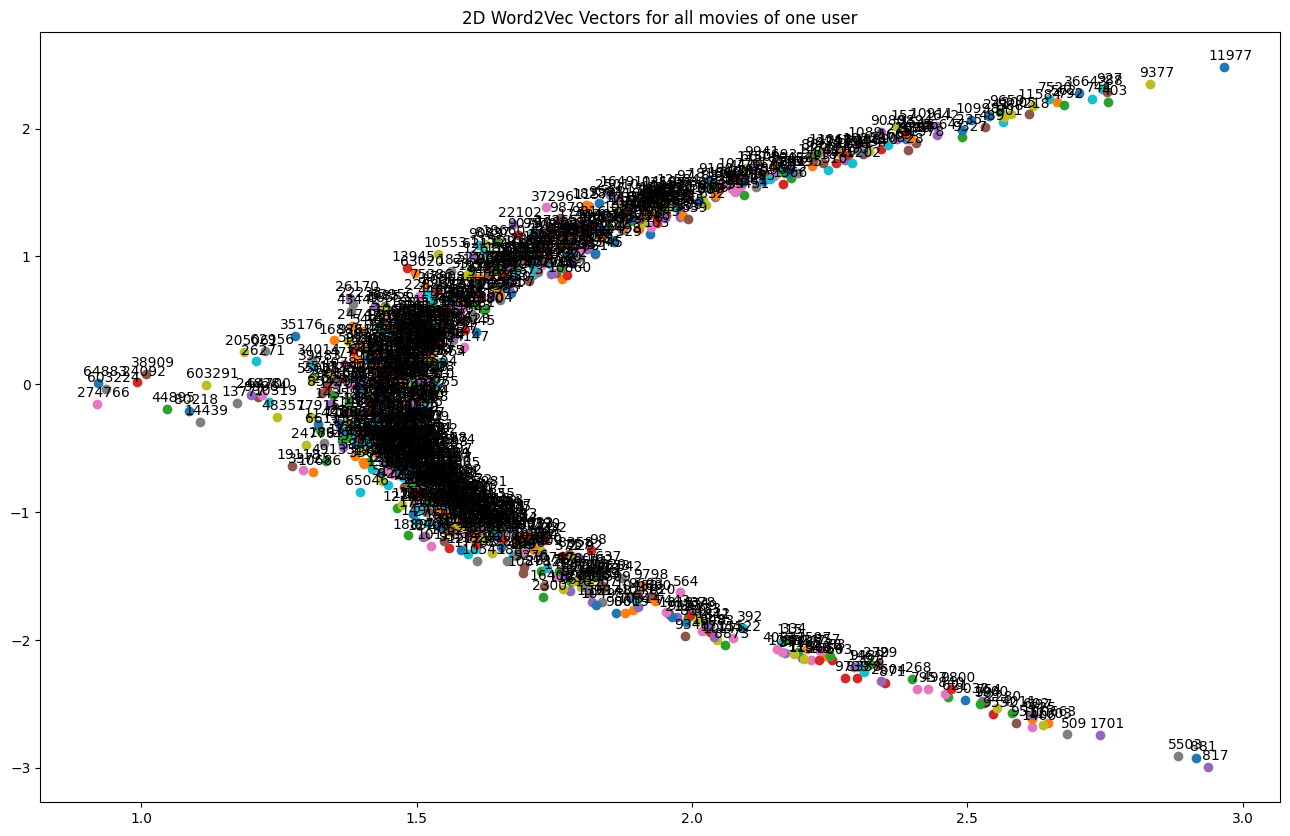

In [6]:
plt.figure(figsize=(16,10))

for movie in movies:
    movie_vector = model.wv[str(movie)]
    x, y = movie_vector[0], movie_vector[1]
    plt.scatter(x,y, label=f"Movie: {movie}")
    plt.annotate(str(movie), (x, y), textcoords="offset points", xytext=(5, 5), ha='center')
    
plt.title("2D Word2Vec Vectors for all movies of one user")
plt.show()

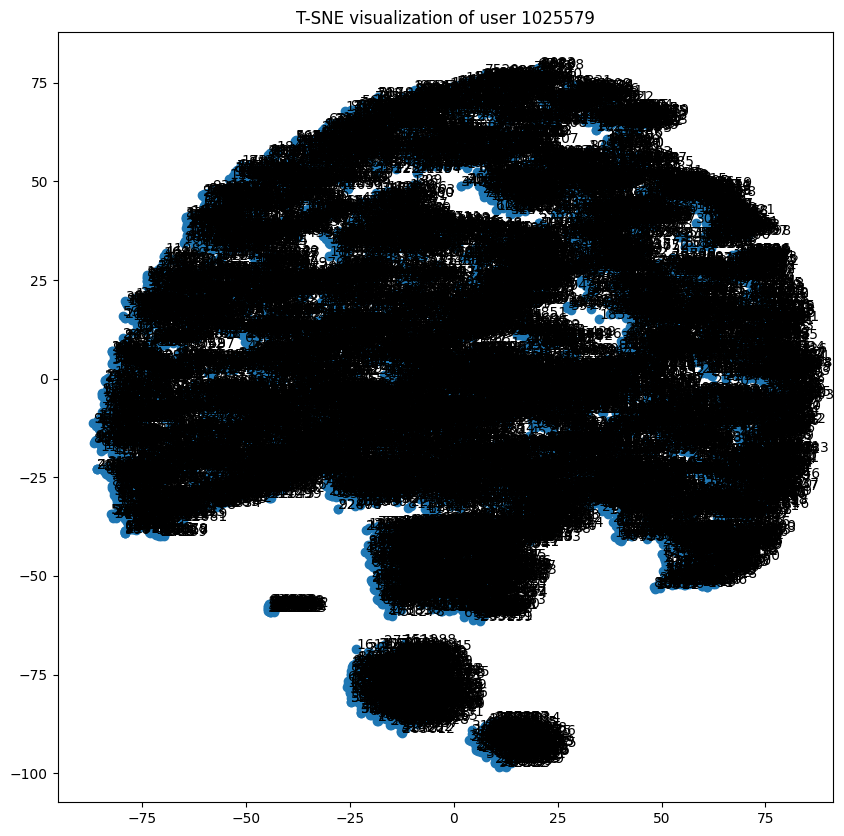

In [6]:
movie_ids = model.wv.index_to_key
# print(f"length_of_movie_ids: {len(movie_ids)}")

# print(f"movie_ids: {movie_ids}, length of movie_ids: {len(movie_ids)}")
movie_vectors = [model.wv[movie_id] for movie_id in movie_ids]

movie_vectors_array = np.array(movie_vectors)
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(movie_vectors_array)
# print(f"length_of_recuded_vectors: {len(reduced_vectors)}")

plt.figure(figsize=(10, 10))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])

for i, movie_id in enumerate(movie_ids):
    plt.annotate(movie_id, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title(f"T-SNE visualization of user {list(users)[0]}")
plt.show()